In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os, time, random, keras, pickle, gc

import tensorflow as tf
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

from face_verification.facenet import basenet
from face_verification.facenet import triplet_net
from face_verification.facenet import triplet_loss
from face_verification.facenet import train_triplet_generator
from face_verification.facenet import test_triplet_generator

%matplotlib inline

Using TensorFlow backend.


# Load Image Dictionary

In [2]:
vgg2_train = pd.read_csv('./images/vgg2_train_path.csv')
vgg2_test = pd.read_csv('./images/vgg2_test_path.csv')

print('Train:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_train['name'].unique()), 
                                                           len(vgg2_train)))
print('Test:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_test['name'].unique()),
                                                          len(vgg2_test)))

vgg2_train.head()

Train:	# person = 8631	 # images = 2113881
Test:	# person =  500	 # images =  116568


,name,path
0,n000002,./images/vgg2_face/train/n000002/0054_01.jpg
1,n000002,./images/vgg2_face/train/n000002/0029_01.jpg
2,n000002,./images/vgg2_face/train/n000002/0202_02.jpg
3,n000002,./images/vgg2_face/train/n000002/0037_01.jpg
4,n000002,./images/vgg2_face/train/n000002/0046_01.jpg


In [3]:
# pre-process the train and test dataframe
def path_to_list(df):
    """ function to merge df into the name and path list format """
    paths = list(df['path'].values)
    count = len(paths)
    
    return pd.Series([count, paths], index=['count', 'paths'])

In [4]:
vgg2_train_df = vgg2_train.groupby('name').apply(path_to_list).reset_index()
vgg2_test_df = vgg2_test.groupby('name').apply(path_to_list).reset_index()

vgg2_train_df.head()

,name,count,paths
0,n000002,198,"[./images/vgg2_face/train/n000002/0054_01.jpg,..."
1,n000003,143,"[./images/vgg2_face/train/n000003/0054_01.jpg,..."
2,n000004,334,"[./images/vgg2_face/train/n000004/0054_01.jpg,..."
3,n000005,67,"[./images/vgg2_face/train/n000005/0430_02.jpg,..."
4,n000006,374,"[./images/vgg2_face/train/n000006/0154_01.jpg,..."


# Define Triplet Network

In [5]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [6]:
# create the base-cnn model
base_model = basenet(output_shape=128)

# # visualization
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.png')
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.pdf')

# base-model summary
base_model.summary()

Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________

In [7]:
# create the triplet-network model
triplet_model = triplet_net(base_model=base_model, input_shape=(96, 96, 3))

# # visualization
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.png')
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.pdf')

# base-model summary
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          3743280     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

# Triplet Network Training

In [8]:
# define learning scheduler
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 900:
        lr *= 1e-1
    elif epoch > 800:
        lr *= 2e-1
    elif epoch > 700:
        lr *= 3e-1
    elif epoch > 600:
        lr *= 4e-1
    elif epoch > 500:
        lr *= 5e-1
    elif epoch > 400:
        lr *= 6e-1
    elif epoch > 300:
        lr *= 7e-1
    elif epoch > 200:
        lr *= 8e-1
    elif epoch > 100:
        lr *= 9e-1
        
    return lr

In [9]:
# define optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))

# create checkpoint folder
path = './models/margin-04-' + time.strftime('%Y%m%d-%H%M')
if not os.path.exists(path):
    os.mkdir(path)
print('Checkpoing Folder:\t', path)    

# create call backs
checkpoint = ModelCheckpoint(filepath=path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', verbose=0, save_best_only=False, 
                             save_weights_only=False, mode='auto', period=10)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# compile the model
triplet_model.compile(optimizer=opt, loss=triplet_loss(0.4))

# define training and test dataset image generator
train_generator = train_triplet_generator(vgg2_train_df, batch_size=128)
test_generator = test_triplet_generator(vgg2_test_df, batch_size=100, loops=10, seed=42)

Checkpoing Folder:	 ./models/margin-04-20180805-0307


In [10]:
# fit the model
history = triplet_model.fit_generator(train_generator, steps_per_epoch=67, epochs=1000, 
                                      validation_data=test_generator, validation_steps=50, 
                                      verbose=2, callbacks=callbacks)

base_model.save(path + '/facenet-model.h5')
pickle.dump(history.history, open(path + '/facenet-history.p', 'wb'))
_ = gc.collect()

Epoch 1/1000
 - 124s - loss: 40.0089 - val_loss: 31.5086
Epoch 2/1000
 - 107s - loss: 32.6067 - val_loss: 32.3811
Epoch 3/1000
 - 103s - loss: 28.6594 - val_loss: 31.6191
Epoch 4/1000
 - 103s - loss: 26.1724 - val_loss: 25.2402
Epoch 5/1000
 - 102s - loss: 23.8639 - val_loss: 25.4233
Epoch 6/1000
 - 104s - loss: 22.7689 - val_loss: 25.3402
Epoch 7/1000
 - 101s - loss: 22.0094 - val_loss: 26.1359
Epoch 8/1000
 - 101s - loss: 20.9979 - val_loss: 22.4610
Epoch 9/1000
 - 100s - loss: 20.6865 - val_loss: 25.9964
Epoch 10/1000
 - 101s - loss: 20.1298 - val_loss: 20.8170
Epoch 11/1000
 - 100s - loss: 19.3858 - val_loss: 16.5570
Epoch 12/1000
 - 99s - loss: 19.2461 - val_loss: 18.6117
Epoch 13/1000
 - 101s - loss: 18.5327 - val_loss: 28.4599
Epoch 14/1000
 - 98s - loss: 18.5019 - val_loss: 23.6473
Epoch 15/1000
 - 98s - loss: 18.3653 - val_loss: 19.4087
Epoch 16/1000
 - 98s - loss: 17.5659 - val_loss: 16.8669
Epoch 17/1000
 - 98s - loss: 16.7823 - val_loss: 14.8842
Epoch 18/1000
 - 97s - loss:

Epoch 146/1000
 - 97s - loss: 8.0648 - val_loss: 7.9215
Epoch 147/1000
 - 98s - loss: 8.3520 - val_loss: 7.2693
Epoch 148/1000
 - 96s - loss: 8.7528 - val_loss: 7.5097
Epoch 149/1000
 - 97s - loss: 8.5136 - val_loss: 8.1548
Epoch 150/1000
 - 97s - loss: 8.2884 - val_loss: 8.3431
Epoch 151/1000
 - 97s - loss: 8.6452 - val_loss: 8.9640
Epoch 152/1000
 - 97s - loss: 8.5878 - val_loss: 8.5065
Epoch 153/1000
 - 97s - loss: 8.8431 - val_loss: 7.9941
Epoch 154/1000
 - 97s - loss: 7.8667 - val_loss: 7.3447
Epoch 155/1000
 - 97s - loss: 8.1747 - val_loss: 7.3608
Epoch 156/1000
 - 96s - loss: 8.1328 - val_loss: 8.5627
Epoch 157/1000
 - 97s - loss: 8.3157 - val_loss: 7.7723
Epoch 158/1000
 - 97s - loss: 8.1300 - val_loss: 6.5810
Epoch 159/1000
 - 97s - loss: 8.1348 - val_loss: 6.7459
Epoch 160/1000
 - 97s - loss: 8.2319 - val_loss: 12.1413
Epoch 161/1000
 - 97s - loss: 8.0119 - val_loss: 8.0014
Epoch 162/1000
 - 97s - loss: 8.0255 - val_loss: 9.2457
Epoch 163/1000
 - 97s - loss: 8.0321 - val_loss

Epoch 293/1000
 - 96s - loss: 6.3306 - val_loss: 6.6296
Epoch 294/1000
 - 97s - loss: 6.2931 - val_loss: 6.4828
Epoch 295/1000
 - 96s - loss: 5.8558 - val_loss: 6.5538
Epoch 296/1000
 - 97s - loss: 6.2583 - val_loss: 6.3919
Epoch 297/1000
 - 97s - loss: 6.6240 - val_loss: 6.7393
Epoch 298/1000
 - 97s - loss: 6.1230 - val_loss: 6.5907
Epoch 299/1000
 - 96s - loss: 6.1465 - val_loss: 5.6400
Epoch 300/1000
 - 97s - loss: 6.7429 - val_loss: 6.4782
Epoch 301/1000
 - 97s - loss: 6.5322 - val_loss: 6.1781
Epoch 302/1000
 - 97s - loss: 6.7549 - val_loss: 6.2731
Epoch 303/1000
 - 97s - loss: 6.3642 - val_loss: 5.4806
Epoch 304/1000
 - 97s - loss: 6.3453 - val_loss: 6.0490
Epoch 305/1000
 - 97s - loss: 6.0176 - val_loss: 6.6804
Epoch 306/1000
 - 97s - loss: 6.2479 - val_loss: 5.8003
Epoch 307/1000
 - 97s - loss: 6.6488 - val_loss: 6.1088
Epoch 308/1000
 - 97s - loss: 5.9501 - val_loss: 6.3639
Epoch 309/1000
 - 97s - loss: 6.1280 - val_loss: 7.2259
Epoch 310/1000
 - 96s - loss: 6.2597 - val_loss:

Epoch 440/1000
 - 97s - loss: 5.2707 - val_loss: 5.1119
Epoch 441/1000
 - 97s - loss: 5.2499 - val_loss: 4.9282
Epoch 442/1000
 - 97s - loss: 5.5826 - val_loss: 5.2444
Epoch 443/1000
 - 97s - loss: 5.6254 - val_loss: 5.7827
Epoch 444/1000
 - 97s - loss: 5.1471 - val_loss: 5.2617
Epoch 445/1000
 - 97s - loss: 5.3999 - val_loss: 4.7270
Epoch 446/1000
 - 97s - loss: 5.5784 - val_loss: 4.7217
Epoch 447/1000
 - 98s - loss: 5.2370 - val_loss: 5.2839
Epoch 448/1000
 - 97s - loss: 5.0280 - val_loss: 4.8210
Epoch 449/1000
 - 98s - loss: 5.2448 - val_loss: 6.2923
Epoch 450/1000
 - 97s - loss: 5.3588 - val_loss: 5.6192
Epoch 451/1000
 - 97s - loss: 4.9527 - val_loss: 5.3286
Epoch 452/1000
 - 97s - loss: 5.2976 - val_loss: 5.6920
Epoch 453/1000
 - 97s - loss: 5.5633 - val_loss: 5.2365
Epoch 454/1000
 - 97s - loss: 5.7810 - val_loss: 6.1209
Epoch 455/1000
 - 97s - loss: 5.5670 - val_loss: 5.4697
Epoch 456/1000
 - 97s - loss: 5.1358 - val_loss: 4.8891
Epoch 457/1000
 - 97s - loss: 5.3054 - val_loss:

Epoch 587/1000
 - 97s - loss: 4.8970 - val_loss: 4.2844
Epoch 588/1000
 - 97s - loss: 5.1592 - val_loss: 4.8619
Epoch 589/1000
 - 97s - loss: 4.9000 - val_loss: 5.4816
Epoch 590/1000
 - 97s - loss: 4.7122 - val_loss: 5.0212
Epoch 591/1000
 - 96s - loss: 4.2835 - val_loss: 5.0790
Epoch 592/1000
 - 98s - loss: 4.4383 - val_loss: 5.5175
Epoch 593/1000
 - 97s - loss: 4.7123 - val_loss: 5.1167
Epoch 594/1000
 - 97s - loss: 4.9227 - val_loss: 4.5683
Epoch 595/1000
 - 97s - loss: 4.9479 - val_loss: 4.5841
Epoch 596/1000
 - 97s - loss: 4.9139 - val_loss: 4.3763
Epoch 597/1000
 - 97s - loss: 4.7471 - val_loss: 4.5207
Epoch 598/1000
 - 97s - loss: 4.6880 - val_loss: 5.3543
Epoch 599/1000
 - 97s - loss: 4.6117 - val_loss: 5.0272
Epoch 600/1000
 - 97s - loss: 4.7195 - val_loss: 4.7083
Epoch 601/1000
 - 97s - loss: 4.7355 - val_loss: 4.9672
Epoch 602/1000
 - 97s - loss: 4.7100 - val_loss: 5.0037
Epoch 603/1000
 - 97s - loss: 5.0393 - val_loss: 5.1975
Epoch 604/1000
 - 97s - loss: 4.5841 - val_loss:

Epoch 734/1000
 - 96s - loss: 4.1393 - val_loss: 3.8429
Epoch 735/1000
 - 97s - loss: 4.3397 - val_loss: 3.9408
Epoch 736/1000
 - 97s - loss: 4.1745 - val_loss: 4.4865
Epoch 737/1000
 - 97s - loss: 3.9926 - val_loss: 4.8354
Epoch 738/1000
 - 97s - loss: 4.0663 - val_loss: 4.2356
Epoch 739/1000
 - 97s - loss: 4.1170 - val_loss: 4.1395
Epoch 740/1000
 - 97s - loss: 4.2838 - val_loss: 4.3525
Epoch 741/1000
 - 97s - loss: 4.1891 - val_loss: 4.1692
Epoch 742/1000
 - 97s - loss: 4.0913 - val_loss: 4.1170
Epoch 743/1000
 - 97s - loss: 4.2084 - val_loss: 3.9948
Epoch 744/1000
 - 97s - loss: 4.1156 - val_loss: 5.0367
Epoch 745/1000
 - 97s - loss: 4.3461 - val_loss: 4.3819
Epoch 746/1000
 - 97s - loss: 4.3319 - val_loss: 3.4154
Epoch 747/1000
 - 97s - loss: 3.9708 - val_loss: 4.3349
Epoch 748/1000
 - 96s - loss: 3.9271 - val_loss: 4.4173
Epoch 749/1000
 - 97s - loss: 4.1776 - val_loss: 4.1981
Epoch 750/1000
 - 97s - loss: 4.7287 - val_loss: 3.7832
Epoch 751/1000
 - 97s - loss: 4.0769 - val_loss:

Epoch 881/1000
 - 97s - loss: 3.8964 - val_loss: 4.1098
Epoch 882/1000
 - 97s - loss: 4.2934 - val_loss: 3.8060
Epoch 883/1000
 - 97s - loss: 3.8445 - val_loss: 3.9350
Epoch 884/1000
 - 98s - loss: 3.7265 - val_loss: 3.6361
Epoch 885/1000
 - 97s - loss: 3.7822 - val_loss: 3.6406
Epoch 886/1000
 - 97s - loss: 3.6720 - val_loss: 4.0093
Epoch 887/1000
 - 97s - loss: 3.9161 - val_loss: 4.0428
Epoch 888/1000
 - 97s - loss: 3.9930 - val_loss: 3.8411
Epoch 889/1000
 - 96s - loss: 3.7850 - val_loss: 3.5592
Epoch 890/1000
 - 97s - loss: 3.8588 - val_loss: 4.2071
Epoch 891/1000
 - 97s - loss: 3.8743 - val_loss: 3.9006
Epoch 892/1000
 - 97s - loss: 3.5432 - val_loss: 3.9718
Epoch 893/1000
 - 97s - loss: 3.7233 - val_loss: 4.1916
Epoch 894/1000
 - 97s - loss: 3.6152 - val_loss: 4.7990
Epoch 895/1000
 - 97s - loss: 3.7192 - val_loss: 3.7411
Epoch 896/1000
 - 97s - loss: 3.8323 - val_loss: 3.4386
Epoch 897/1000
 - 97s - loss: 4.0119 - val_loss: 3.9261
Epoch 898/1000
 - 97s - loss: 3.7727 - val_loss:

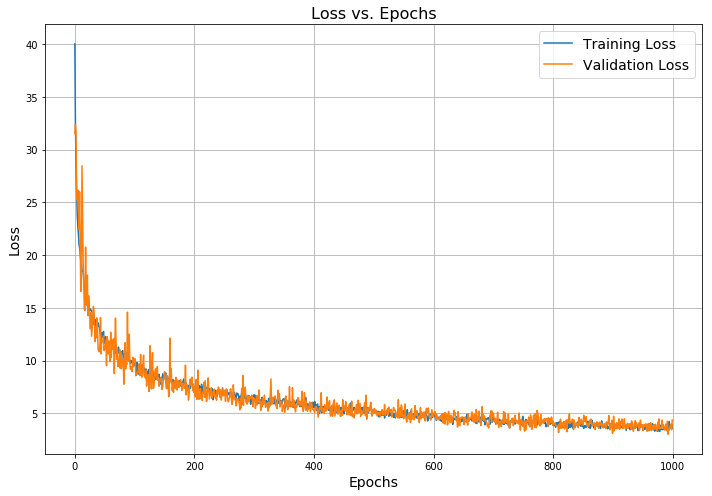

In [11]:
# Visualize the training process
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss vs. Epochs', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.show()